In [1]:
# For Jupyter notebook
import sys
sys.path.append('..')

In [2]:
from models.detectors import create_detector
import torch
import torchvision
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# comment if already downloaded pre-trained weights
# download pretrained mmdetection model from model zoo
#torch.utils.model_zoo.load_url(
    # 'https://s3.ap-northeast-2.amazonaws.com/open-mmlab/mmdetection/models/retinanet_r101_fpn_1x_20181129-f016f384.pth',
    # model_dir='.');

In [4]:
# create RetinaNet with ResNet 101 backbone, and pretrained COCO weights
# Note: COCO has 80 classes plus one background class
retina = create_detector('retinanet_r101_fpn', number_of_classes=81, pretrained='../../../retinanet_r101_fpn_1x_20181129-f016f384.pth')


In [5]:
# Extract frames from video every 10 mins
# Opens the Video file caption
cap= cv2.VideoCapture('timelapse_barbershop_1.mp4') 

#Get frames per second for video to calculate reat time
#Note that this video is timelapse at about 10x 9.84 exact
fps = cap.get(cv2.CAP_PROP_FPS)
print("Video Caption fps: ",fps)
frameList = [] #key = timestamp, value = frame name
#set number of frames to skip
framesToSkip = 960
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i % framesToSkip == 0: # Save one frame every 120
        cv2.imwrite('frame_'+str(i)+'.jpg',frame)
        frameTimestamp = int(i / fps) #must be int not float
        frameImg = 'frame_'+str(i)+'.jpg'
        frameList.append({frameTimestamp:frameImg})
    i+=1

cap.release()
cv2.destroyAllWindows()
print ("Frame List:", frameList)

Video Caption fps:  9.845242015146527
Frame List: [{0: 'frame_0.jpg'}, {97: 'frame_960.jpg'}, {195: 'frame_1920.jpg'}]


Frame: frame_0.jpg  --Count:  9  --Timestamp(sec):  0
Frame: frame_960.jpg  --Count:  7  --Timestamp(sec):  97
Frame: frame_1920.jpg  --Count:  6  --Timestamp(sec):  195


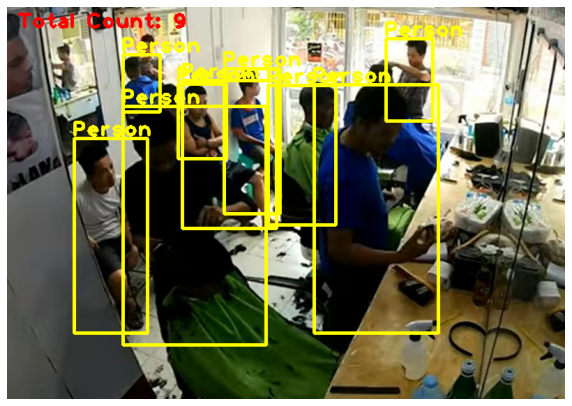

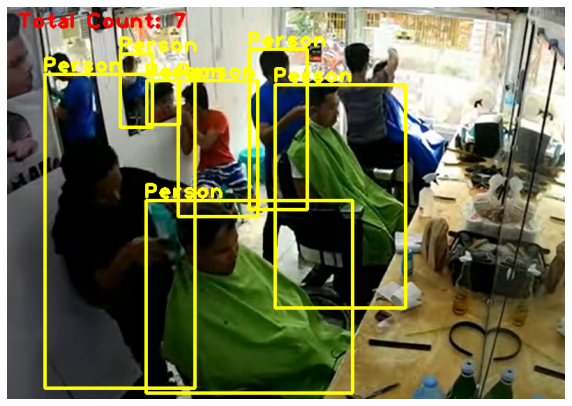

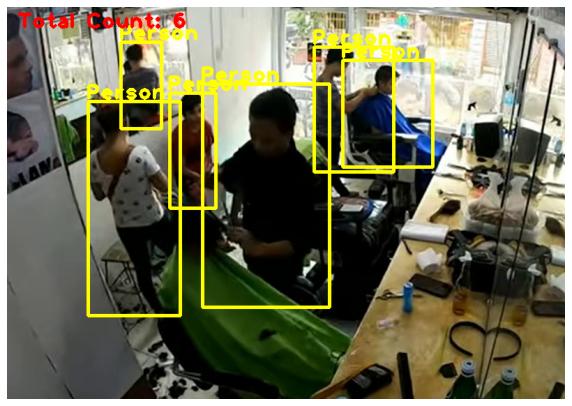

In [8]:
for frame in frameList:

    for timestamp, image in frame.items():

        with torch.no_grad():
            result = retina.detect(image)
        res = []

        # Look for cars [2], person [0] in COCO dataset, with threshold between 0.3-0.5 depending on setting
        for r in result[0]:
            if r[-1] >= 0.5:
                res.append(r[:-1].astype(dtype=np.int).tolist())

        if len(res) > 0:
            im = cv2.imread(image)
            for r in res:
                cv2.rectangle(im, (r[0], r[1]), (r[2], r[3]), (0, 255, 255), 3)
                cv2.putText(im, "Person", (r[0]-3, r[1]-3), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 255), 3)
            
            print("Frame:",image," --Count: ", len(res), " --Timestamp(sec): ", timestamp)
            #convert image to color
            im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
            #print text in frame of total count
            cv2.putText(im, "Total Count: " + str(len(res)), (15, 30), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 3)
            plt.figure(figsize=(10,11))
            plt.axis("off")
            plt.imshow(im)
            
